In [1]:
# Import libraries
import os
import cv2
import time
import json
import copy
import pandas as pd
import albumentations as albu
import matplotlib.pyplot as plt
import albumentations as albu
from tqdm import tqdm

import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Dataset link: https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data
BASE_DIR = "./cassava-leaf-disease-classification/"
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR, 'train_images')

train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))

train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
print("Count of training images {0}".format(len(os.listdir(TRAIN_IMAGES_DIR))))

Count of training images 21397


In [4]:
with open(f'{BASE_DIR}/label_num_to_disease_map.json', 'r') as f:
    name_mapping = json.load(f)
    
name_mapping = {int(k): v for k, v in name_mapping.items()}
train_df["class_id"] = train_df["label"].map(name_mapping)

In [5]:
name_mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

# Visualization

In [6]:
def visualize_images(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for idx,(image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, idx + 1)
        
        image=cv2.imread(os.path.join(TRAIN_IMAGES_DIR, image_id))
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        
        plt.axis("off")
    plt.show()
    

def plot_augmentation(image_id, transform):
    plt.figure(figsize=(16, 4))
    
    img = cv2.imread(os.path.join(TRAIN_IMAGES_DIR, image_id))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    x = transform(image = img)["image"]
    plt.imshow(x)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    x = transform(image = img)["image"]
    plt.imshow(x)
    plt.axis("off")
    
    plt.show()
    
    
def visualize(images, transform):
    """
    Plot images and their transformations
    """
    fig = plt.figure(figsize=(32, 16))
    
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        plt.imshow(im)
        
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i + 6, xticks=[], yticks=[])
        plt.imshow(transform(image=im)['image'])

# Modelling

In [7]:
# Custom Dataset
class CassavaDataset(Dataset):
    def __init__(self, input_labels, image_path, train = True, transforms=None):
        self.input_labels = input_labels
        self.image_path = image_path
        self.train = train
        self.transforms = transforms
        
    def __getitem__(self, index):
        im_path = os.path.join(self.image_path, self.input_labels.iloc[index]['image_id'])
        x = cv2.imread(im_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        if(self.transforms):
            x = self.transforms(image=x)['image']
        
        if(self.train):
            y = self.input_labels.iloc[index]['label']
            return x, y
        else:
            return x
        
    def __len__(self):
        return len(self.input_labels)

In [8]:
train_augs = albu.Compose([
    albu.RandomResizedCrop(height=384, width=384, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.ShiftScaleRotate(p=0.5),
    albu.Normalize(    
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    ToTensorV2(),
])

valid_augs = albu.Compose([
    albu.Resize(height=384, width=384, p=1.0),
    albu.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    ToTensorV2(),
])

In [9]:
train, valid = train_test_split(
    train_df, 
    test_size=0.1, 
    random_state=42,
    stratify=train_df.label.values
)


# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.label.values

# targets for validation
valid_targets = valid.label.values

In [10]:
train_dataset = CassavaDataset(
    input_labels=train,
    image_path=TRAIN_IMAGES_DIR,
    train=True,
    transforms=train_augs
)

valid_dataset = CassavaDataset(
    input_labels=valid,
    image_path=TRAIN_IMAGES_DIR,
    train=True,
    transforms=valid_augs
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


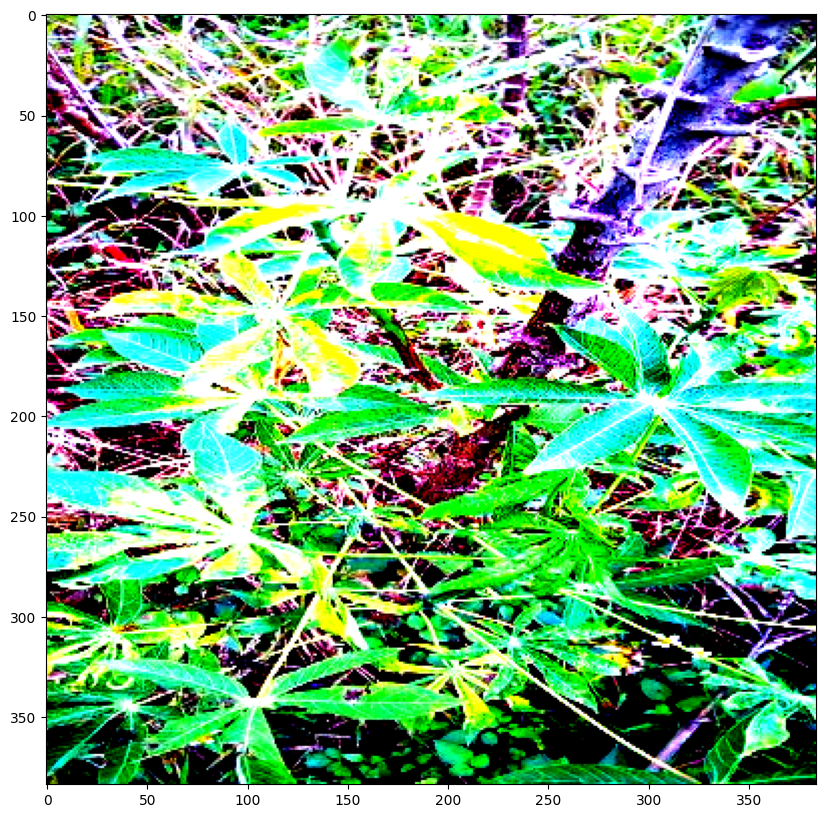

In [11]:
def plot_image(img_dict):
    image_tensor = img_dict[0]
    target = img_dict[1]
    print(target)
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0) 
    plt.imshow(image)
    
plot_image(train_dataset[0])


In [13]:
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            
            train_bar = tqdm(dataloaders[phase], desc=f"Training")
            for _, (inputs, labels) in enumerate(train_bar):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # Statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = running_corrects.double()/len(datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model

In [14]:
# importig our custom ViT model
from vit import ViT
# Set some parameters
num_layers = 6
num_heads = 6
d_model = 384
fully_connected_dim = 4 * d_model
image_size = 384
patch_size = 16
channels = 3
num_classes = 5
dropout_rate = 0.1
layernorm_eps = 1e-6

# Instantiate the ViT model
model = ViT(num_layers=num_layers, num_heads=num_heads, d_model=d_model, fully_connected_dim=fully_connected_dim,
            image_size=image_size, patch_size=patch_size, channels=channels, num_classes=num_classes,
            dropout_rate=dropout_rate, layernorm_eps=layernorm_eps)

In [15]:
datasets={'train':train_dataset, 'valid':valid_dataset}
dataloaders={'train':train_loader, 'valid':valid_loader}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [16]:
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            
            train_bar = tqdm(dataloaders[phase], desc=f"Training")
            for _, (inputs, labels) in enumerate(train_bar):
                inputs = inputs.to(device)
                labels=labels.to(device)

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model=model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # Statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = running_corrects.double()/len(datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [17]:
num_epochs = 5

trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

Epoch 0/4
----------


Training: 100%|██████████| 602/602 [01:43<00:00,  5.82it/s]


train Loss: 1.0768 Acc: 0.6282


Training: 100%|██████████| 67/67 [00:04<00:00, 14.35it/s]


valid Loss: 1.0031 Acc: 0.6336

Epoch 1/4
----------


Training: 100%|██████████| 602/602 [01:43<00:00,  5.83it/s]


train Loss: 0.9452 Acc: 0.6529


Training: 100%|██████████| 67/67 [00:04<00:00, 13.86it/s]


valid Loss: 0.8997 Acc: 0.6612

Epoch 2/4
----------


Training: 100%|██████████| 602/602 [01:43<00:00,  5.82it/s]


train Loss: 0.8480 Acc: 0.6843


Training: 100%|██████████| 67/67 [00:04<00:00, 14.01it/s]


valid Loss: 0.8686 Acc: 0.6841

Epoch 3/4
----------


Training: 100%|██████████| 602/602 [01:43<00:00,  5.81it/s]


train Loss: 0.8303 Acc: 0.6913


Training: 100%|██████████| 67/67 [00:04<00:00, 14.06it/s]


valid Loss: 0.8367 Acc: 0.6930

Epoch 4/4
----------


Training: 100%|██████████| 602/602 [01:43<00:00,  5.82it/s]


train Loss: 0.8155 Acc: 0.6947


Training: 100%|██████████| 67/67 [00:04<00:00, 13.94it/s]

valid Loss: 0.8282 Acc: 0.6972

Training complete in 9m 1s
Best val Acc: 0.697196


In [18]:
torch.save(model.state_dict(), 'vit_cassava.pt')